In [2]:
import pandas as pd
import polars as pl
import duckdb as db
import numpy as np

import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo 
from collections import Counter

from random import sample

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy.stats import binomtest, ks_2samp

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Lecture 3

For today's lecture I am using Chapters 2 and 7, and Sections 13.3 and 14.2 of "Elements of Statistical Learning" by Hastie et.al.

## Data Types

Let us start by data types we are going to encounter. There are 3 main types of data:

* numerical
* unordered categorical
* ordered categorical

### Numerical data

This is the data type we are familiar with. Data usually consists of a set of vectors of a fixed dimension. For example:

In [3]:
iris = fetch_ucirepo(id=53) 
  
X = iris.data.features 
y = iris.data.targets 

X

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [7]:
X.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In this example, we have 150 data points each of which is a 4-dimensional numerical vector.

### Unordered categorical data

The data need not be numerical, it can also be a collection of labels. Such non-numerical data is also called *categorical data*, *discrete data*, or 
as *factors*.  For example, in the example above, we have labels associated with each of the 4-dimensional vectors as:

In [5]:
y

,class
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


In [11]:
Counter(y['class'])

Counter({'Iris-setosa': 50, 'Iris-versicolor': 50, 'Iris-virginica': 50})

As you can see from the example, there is no inherent ordering in the labels, and often these labels are *descriptive* rather than *qualitative*.

### Ordered categorical data

The last data type we are going to consider is *ordered categorical*. This type of data consists data points of labels such as small, medium and large, where there is an inherent ordering of the values, but there is no specific metric notion.  In other words, the difference between values such as medium and small, and large and medium need not be the same.

Consider the following example: The data is taken from

> Stamey, T., Kabalin, J., McNeal, J., Johnstone, I., Freiha, F., Redwine, E. and Yang, N. "Prostate specific antigen in the diagnosis and
treatment of adenocarcinoma of the prostate II radical prostatectomy treated patients", Journal of Urology 16: 1076–1083.

It consists of 11 columns. Some of the columns are numerical, some are categorical.

In [12]:
prostate_cancer = pd.read_csv('https://raw.githubusercontent.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/master/data/Prostate%20Cancer.txt')
prostate_cancer

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...,...
92,93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [14]:
prostate_cancer.describe()

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,49.000000,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,28.145456,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,1.000000,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,25.000000,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,49.000000,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,73.000000,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,97.000000,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


In [13]:
Counter(prostate_cancer['gleason'])

Counter({7: 56, 6: 35, 9: 5, 8: 1})

In [15]:
Counter(prostate_cancer['svi'])

Counter({0: 76, 1: 21})

In [17]:
Counter(prostate_cancer['train'])

Counter({'T': 67, 'F': 30})

## Understanding Randomness and Differences: Statistical Tests

Consider the following hypothetical problem: let us assume I *randomly* took a 25% sample from the prostate cancer data above:

In [68]:
N = prostate_cancer.shape[0]
m = int(N*0.25)

sample = prostate_cancer.sample(m)

Counter(sample['svi'])
Counter(prostate_cancer['svi'])

Counter({0: 16, 1: 8})

Counter({0: 76, 1: 21})

Here is an important question: 

> **Does the sample share the same statistical properties of the original dataset? Arey they similar or different? If different, why? If same, why?**

When we say *different* what we mean is *statistically significantly different*. The main question is how do we test if there is any difference between the sample and the original dataset?

In this example, since the variable is a binary categorical variable, we use the [binomial test](https://sites.utexas.edu/sos/guided/inferential/categorical/univariate/binomial/).

In [70]:
binomtest(8, 24, 21/(21+76))

BinomTestResult(k=8, n=24, alternative='two-sided', statistic=0.3333333333333333, pvalue=0.21069219272110162)

This test tells us

> We fail to a difference between the distribution of the sample and the distribution of the original sample.

Unlike regular mathematics where a *double negation* is an affirmation (not not A is equivalent to A) in statistical language a double negation "we fail to verify A is not the same as B" is NOT an affirmation. In other words, failing to detect a difference DOES NOT NECESSARILY indicate that they are the same.

How about numerical variables? Consider the following distributions:

(array([ 4.,  0.,  1.,  2.,  3.,  4.,  8.,  9.,  8.,  9., 15., 11.,  5.,
         9.,  3.,  1.,  1.,  1.,  1.,  2.]),
 array([-0.4307829 , -0.13009715,  0.17058861,  0.47127437,  0.77196012,
         1.07264587,  1.37333163,  1.67401738,  1.97470314,  2.27538889,
         2.57607465,  2.8767604 ,  3.17744616,  3.47813192,  3.77881767,
         4.07950343,  4.38018918,  4.68087494,  4.98156069,  5.28224645,
         5.5829322 ]),
 <BarContainer object of 20 artists>)

(array([43.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  1.,  6.,  3.,  0.,  2.,
         1.,  8.,  5., 11.,  3.,  5.,  5.]),
 array([-1.38629436, -1.20066456, -1.01503476, -0.82940496, -0.64377516,
        -0.45814536, -0.27251557, -0.08688577,  0.09874403,  0.28437383,
         0.47000363,  0.65563343,  0.84126323,  1.02689303,  1.21252283,
         1.39815263,  1.58378242,  1.76941222,  1.95504202,  2.14067182,
         2.32630162]),
 <BarContainer object of 20 artists>)

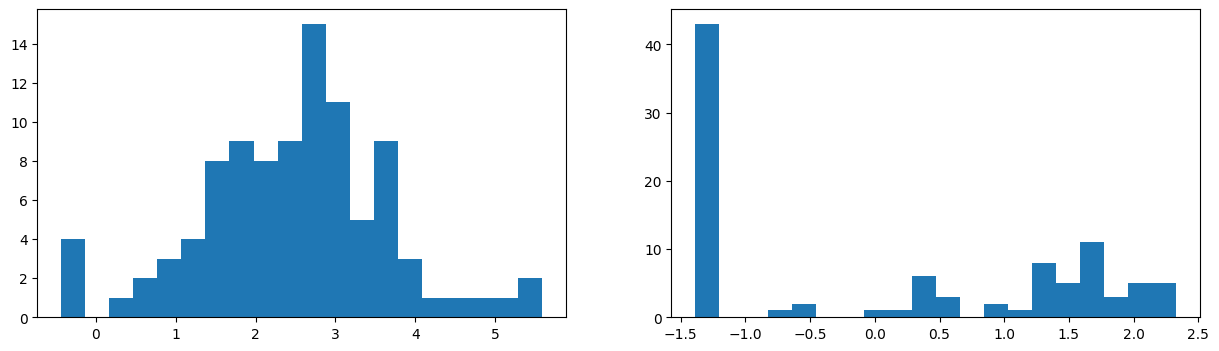

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].hist(prostate_cancer['lpsa'], bins=20)
ax[1].hist(prostate_cancer['lbph'], bins=20)

One possible way of testing two continuous random variables are different, is to use a *[goodness-of-fit test](https://online.stat.psu.edu/stat504/lesson/2/2.4)* such as [Kolmogorov-Simirnov test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm).

In [84]:
ks_2samp(prostate_cancer['lbph'],prostate_cancer['lpsa'])

KstestResult(statistic=0.6082474226804123, pvalue=4.7360022535974636e-17, statistic_location=1.76644166, statistic_sign=1)

## Supervised vs Unsupervised Learning

### Supervised learning

In the simplest terms, if our task is to understand/predict a collection of data points (the response variables, the dependent variables) in terms of other data points (the independent variables), then we are tasked with solving a **supervised learning** problem. We need to come up with a mathematical/statistical/computational model that explains the response variable in terms of the independent variables. The type of the response variable also is important. If the response variable is *categorical* then the problem is called a *classification* problem.

Consider the example datasets we looked at earlier. In the Iris example, if we try to predict the labels by looking at the 4-dimensional vectors, we are trying to solve a classification problem. On the other hand, if try to predict LPSA levels by looking at other variables, the problem is not a classification problem, but a generic numerical supervised learning problem.

#### A simple classification example: k-nearest neighbor (k-NN) models

Let us consider the Iris dataset we described above. Let us construct a model that predicts the labels from their 4-dimensional coordinates. I am going to use a model type called *k-nearest neighbor (k-NN) models*. Here is a mathematical description of the problem:

We have a collection of data points $\mathcal{D} = (\mathbf{x}^{(i)})_{i=1,\ldots,N}$ in an affine space $\mathbb{R}^m$, and a collection of labels $(\ell^{(i)})_{i=1,\ldots,N}$. Let $L$ be the set of all distinct labels. Our prediction model is going to be a function $f\colon \mathcal{D}\to L$ such that $f(x^{(i)})$ needs to recover the label $y^{(i)}$ for every $i=1,\ldots,N$. However, unlike the functions you are familiar with in algebra and calculus, this is not a polynomial, or an analytic function such as $\sin$, $\cos$, or $\log$. Rather, the function will be described *computationally*.

     Algorithm KNN
     Input: A labeled dataset D of m-dimensional vectors
            A set of associated labels y
            An m-dimensional numerical vector v=(v_1,...,v_m) 
            An odd number k
     Output: A label l
     Begin:
       Find k-points in D that are closest to v.
       Record the labels l_1,...,l_k of these points.
       Count each label. 
       Return the label with the highest count.
     End

KNeighborsClassifier(n_neighbors=3)

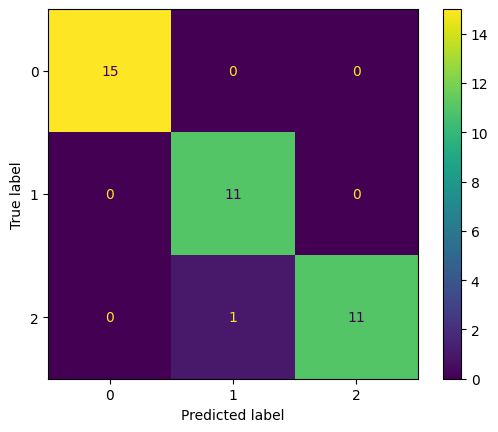

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y['class'],train_size=0.75)

model = KNN(n_neighbors=3)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)

cm = confusion_matrix(y_test,y_predict)
ConfusionMatrixDisplay(cm).plot()

### Unsupervised learning

On the other hand, if we only have data points, and a response variable is not given, then we are solving a **unsupervised learning** problem.

Consider the following data. For a detailed description see Chapter 1 of "Elements of Statistical Learning":

In [24]:
tumor = pd.read_csv('https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/raw/master/data/nci.data.csv')
tumor

,gene,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s55,s56,s57,s58,s59,s60,s61,s62,s63,s64
0,g1,0.300,0.679961,0.940,0.28000,0.485,0.31000,-0.83000,-0.19000,0.46000,...,0.010,-0.62000,-0.380,0.049980,0.650,-0.03000,-0.27000,0.210,-0.05000,0.35000
1,g2,1.180,1.289961,-0.040,-0.31000,-0.465,-0.03000,0.00000,-0.87000,0.00000,...,-1.280,-0.13000,0.000,-0.720020,0.640,-0.48000,0.63000,-0.620,0.14000,-0.27000
2,g3,0.550,0.169961,-0.170,0.68000,0.395,-0.10000,0.13000,-0.45000,1.15000,...,-0.770,0.20000,-0.060,0.419980,0.150,0.07000,-0.10000,-0.150,-0.09000,0.02000
3,g4,1.140,0.379961,-0.040,-0.81000,0.905,-0.46000,-1.63000,0.08000,-1.40000,...,0.940,-1.41000,0.800,0.929980,-1.970,-0.70000,1.10000,-1.330,-1.26000,-1.23000
4,g5,-0.265,0.464961,-0.605,0.62500,0.200,-0.20500,0.07500,0.00500,-0.00500,...,-0.015,1.58500,-0.115,-0.095020,-0.065,-0.19500,1.04500,0.045,0.04500,-0.71500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6825,g6826,-0.030,-0.860039,-0.150,-0.30000,0.605,-0.40000,0.47000,-0.09000,-0.33000,...,-0.160,0.31000,-0.840,0.219980,0.220,-0.02000,-0.16000,0.390,-0.35000,0.48000
6826,g6827,0.000,-1.250049,0.000,-1.15001,0.000,0.69999,0.12999,-0.70001,-0.60001,...,0.000,-1.33001,0.000,-1.100029,0.000,-1.39001,-0.02001,0.000,-0.36001,0.96999
6827,g6828,0.280,-0.770039,-0.120,1.09000,0.745,0.29000,-0.30000,-0.54000,0.83000,...,0.150,-1.21000,-0.580,-0.520019,-0.870,-1.15000,-0.64000,0.160,-0.49000,0.29000
6828,g6829,-0.340,-0.390039,-0.410,-0.26000,0.425,0.55000,0.57000,-0.45000,-0.03000,...,-0.530,0.30000,-0.470,-0.550019,-0.330,0.29000,-0.37000,2.030,0.01000,-0.15000


In [25]:
tumor.describe()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s55,s56,s57,s58,s59,s60,s61,s62,s63,s64
count,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,...,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000,6830.000000
mean,0.065301,0.050764,0.072187,0.093829,0.148587,0.051984,0.045946,0.034898,0.030766,0.071970,...,-0.043875,0.016278,-0.004496,-0.019257,0.040632,0.065602,0.040685,0.072230,0.021698,0.039845
std,0.724547,0.771361,0.679115,0.900368,0.992909,0.800463,0.831638,0.771968,0.675583,0.913155,...,0.901086,0.888810,0.794938,0.831060,0.756366,0.833817,0.688268,0.741078,0.816991,0.721280
min,-5.535000,-5.605039,-3.040020,-4.880000,-4.680000,-5.050000,-4.280000,-5.520000,-4.240000,-4.795000,...,-5.550000,-5.899961,-6.100020,-6.120039,-4.865000,-5.130010,-3.570020,-3.400010,-4.960000,-4.420000
25%,-0.303738,-0.330039,-0.280000,-0.409976,-0.400000,-0.390000,-0.405000,-0.375000,-0.315000,-0.380000,...,-0.430000,-0.410000,-0.385000,-0.380020,-0.369995,-0.380000,-0.320000,-0.335000,-0.410000,-0.330000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.335000,0.359942,0.309998,0.445015,0.514988,0.425007,0.445000,0.385000,0.310000,0.403755,...,0.390000,0.425000,0.364368,0.384348,0.370000,0.430000,0.320032,0.383748,0.405000,0.360000
max,6.175000,7.219961,6.374990,7.565000,7.425000,7.715000,8.660000,5.650000,5.145000,7.635010,...,8.180000,6.150000,6.500000,5.999980,6.200000,5.600000,5.359990,5.495000,5.790000,6.225000


### A simple clustering example

The clustering problem looks very similar to the classification problem. We again have a collection of data points $\mathcal{D}=\mathbf{x}^{(i)}$ in an affine space $\mathbb{R}^m$. Again, we are going to write a function (depending on $\mathcal{D}$) $f\colon \mathcal{D}\to L$ where $L$ is a finite set of labels.  However, unlike classification problems, we don't have a response variable to guide us in writing the labels. This time, we need to consider the data's internal structure and devise a division scheme to split the data into disjoint bags.

This time, we will use a commonly used clustering algorithm [k-means clustering algorithm](https://www.math.ucdavis.edu/~strohmer/courses/180BigData/180lecture_kmeans.pdf).


     Algorithm K-Means
     Input: A dataset of m-dimensional vectors
            A number k that indicates the number of clusters
     Output: k Centroids
     Begin
        Randomly choose k points c^{(1)}, ... , c^{(k)} from D as centroids.
        Do
           Let B_1, ... , B_k be k-many sets initially set to the empty set
           For each point x:
              Let c^{(i)} be the closest centroid to x.
              Add x to the set B_i.
           End for
           For each i from 1 to k:
              Let z^{(i)} be the centroid for the set B_i
              Let epsilon_i be the distance between c^{(i)} and z^{(i)}
           End for
        Until every epsilon (epsilon_1, ... , epsilon_k) is small enough
        Return (c^{(1)}, ... , c^{(k)})
    End
        

In [26]:
X = tumor.iloc[:,1:]
model = KMeans(n_clusters=3, n_init='auto')

model.fit(X)
labels = model.predict(X)

KMeans(n_clusters=3, n_init='auto')

In [27]:
projection = LDA(n_components=2)
res = projection.fit_transform(X,labels)

<Figure size 800x800 with 0 Axes>

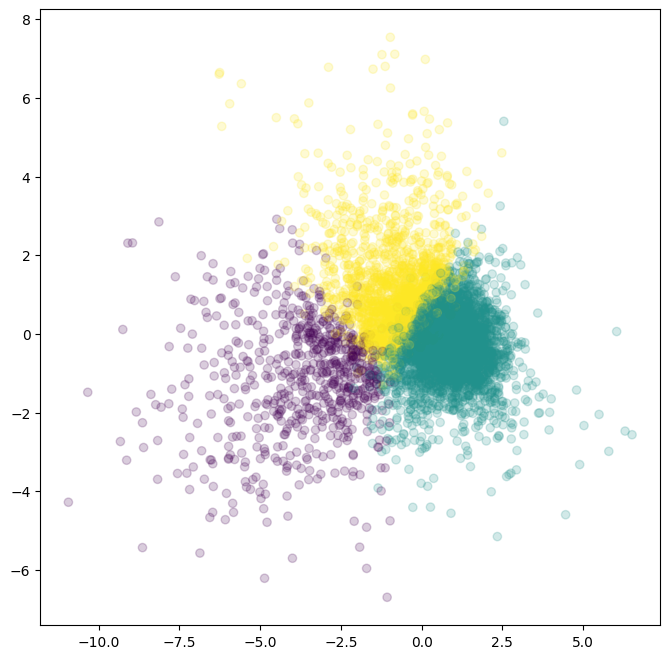

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(res[:,0],res[:,1],c=labels,alpha=0.2)

In [93]:
res[0]

array([-0.62485918, -0.080799  ])